In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import json
from matplotlib.patches import Rectangle
from PIL import Image
import numpy as np
BORDER_WIDTH = 10
def extract_boxes(filename): # helper to extract bounding boxes from json
    f = open(filename,)
    data = json.load(f)

    boxes = [] # store box coordinates in a dictionary corresponding to labels

    for i in data['shapes']:
        if i['shape_type'] == 'rectangle':
            box = {'points': i['points'], 'label': i['label']}
            boxes.append(box)

    return data, boxes

def overlap_area(gen_bb, data_bb):
    (x1, y1), w1, h1 = gen_bb.xy, gen_bb.get_width(), gen_bb.get_height()
    (x2, y2), w2, h2 = data_bb.xy, data_bb.get_width(), data_bb.get_height()
    x = max(x1, x2)
    y = max(y1, y2)
    w = min(x1 + w1, x2 + w2) - x
    h = min(y1 + h1, y2 + h2) - y
    w = w if w > 0 else 0
    h = h if h > 0 else 0
    return Rectangle((x, y), w, h)

def process_image(path):
    img = cv2.imread(path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #grayscale
    blurred_img = cv2.GaussianBlur(img_gray, (21, 21), 0) #add blur so we don't detect super small stuff
    _, mask = cv2.threshold(blurred_img, thresh=200, maxval=255, type=cv2.THRESH_BINARY) #maybe we need to try different
    # thresholds
    img_thresh_gray = cv2.bitwise_and(blurred_img, mask) #apply mask
    img_border = cv2.copyMakeBorder(img_thresh_gray, BORDER_WIDTH, BORDER_WIDTH,BORDER_WIDTH,BORDER_WIDTH, cv2.BORDER_CONSTANT, value=[255, 255, 255])
    contours, hierarchy = cv2.findContours(img_border, cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    return img, img_border, contours

def get_max_bb(points):
    x, y = zip(*points)
    min_x = min(x)
    min_y = min(y)
    max_x = max(x)
    max_y = max(y)
    return [(min_x, min_y), (max_x, max_y)]

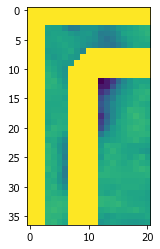

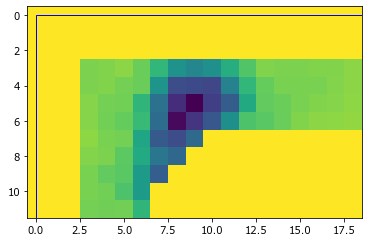

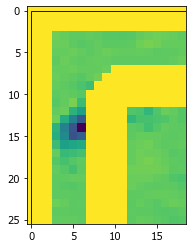

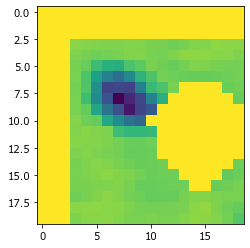

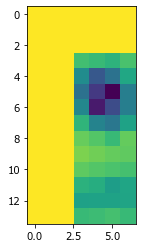

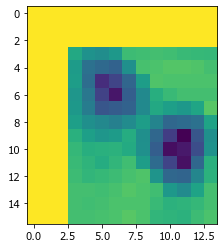

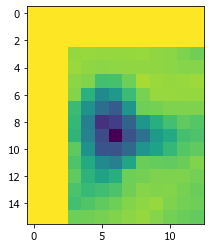

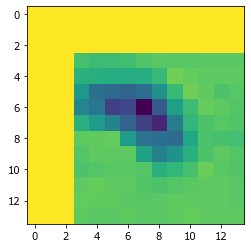

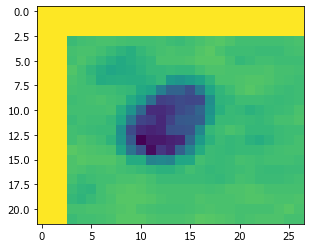

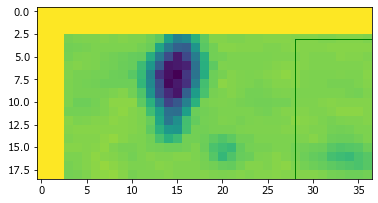

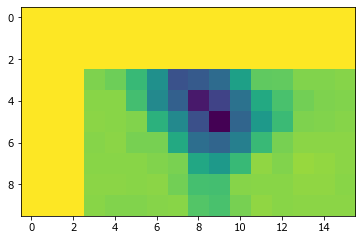

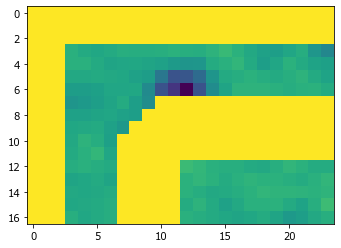

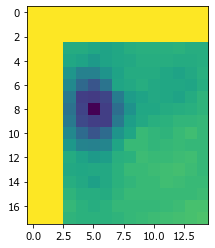

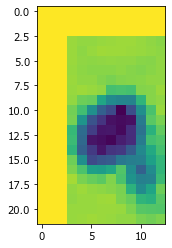

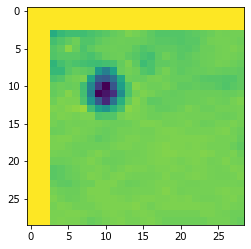

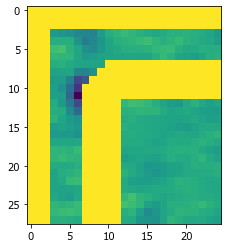

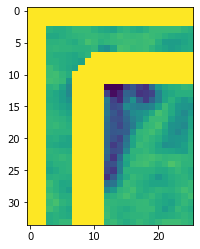

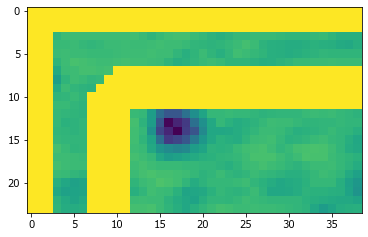

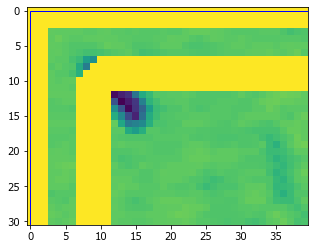

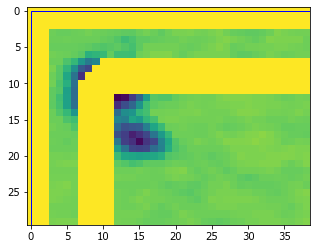

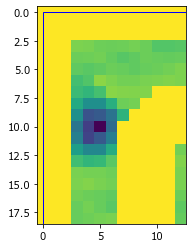

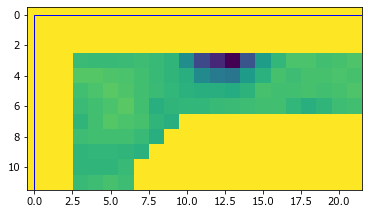

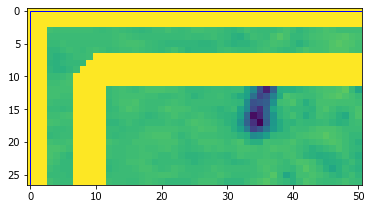

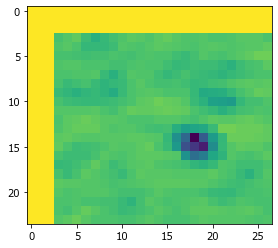

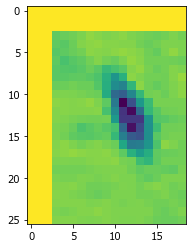

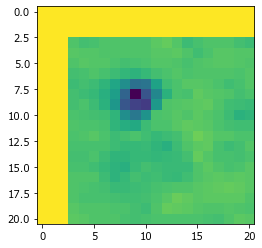

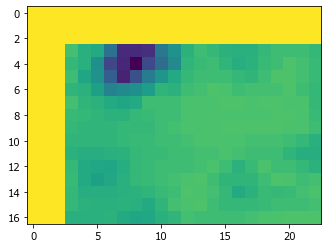

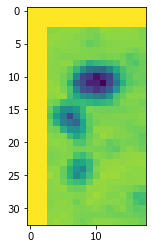

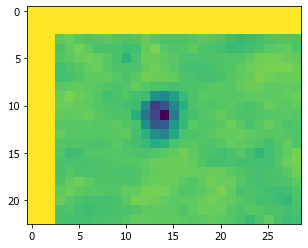

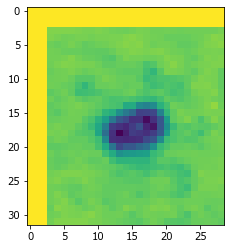

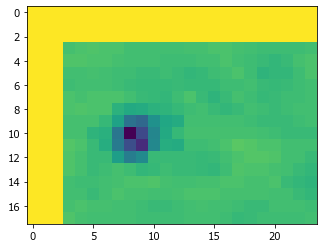

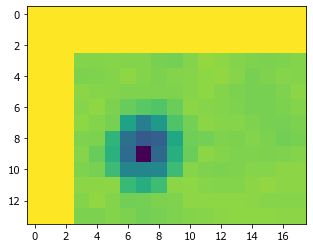

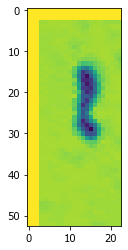

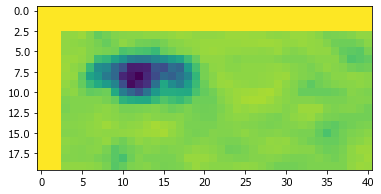

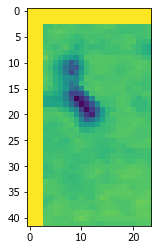

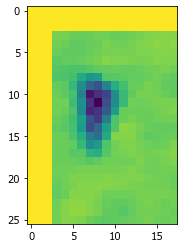

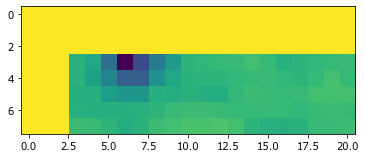

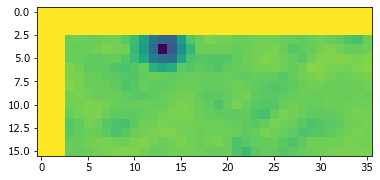

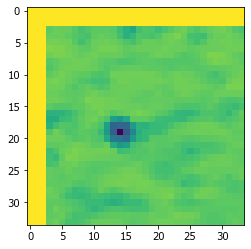

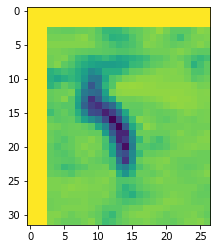

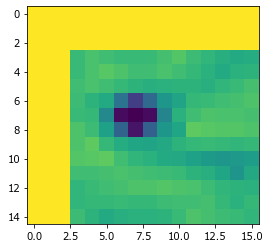

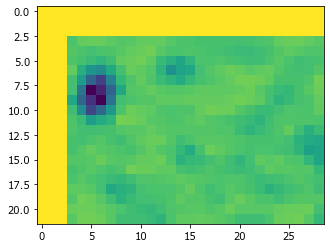

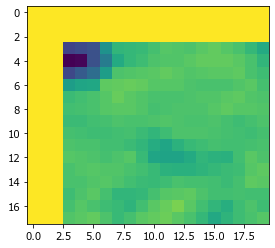

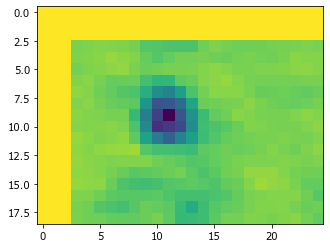

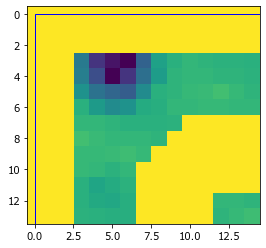

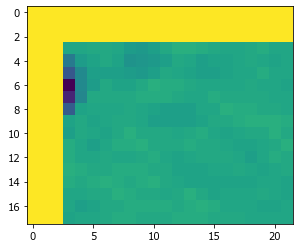

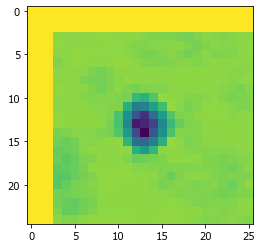

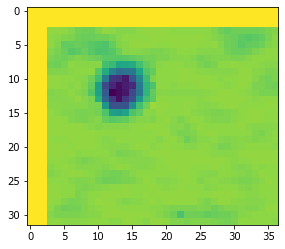

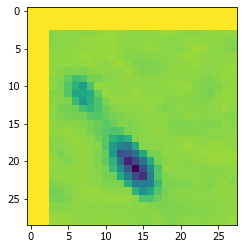

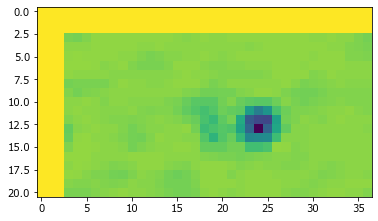

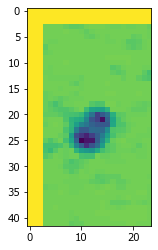

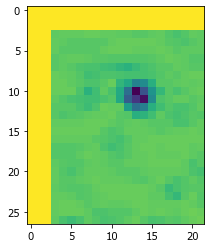

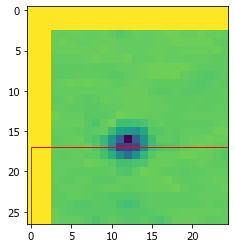

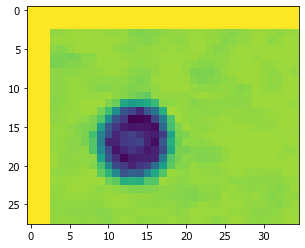

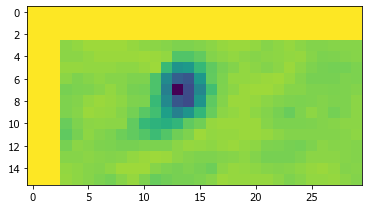

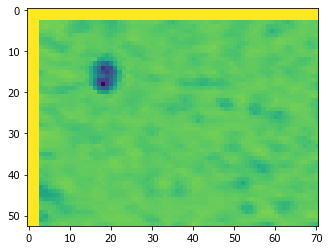

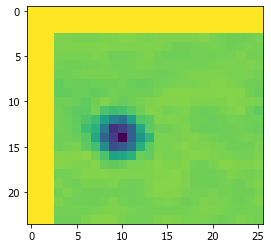

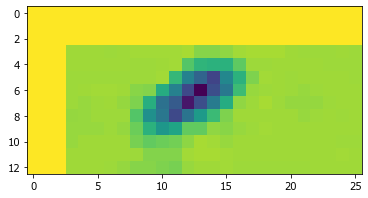

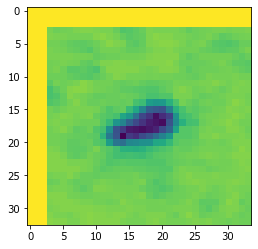

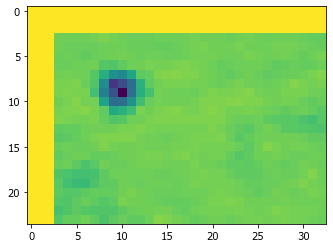

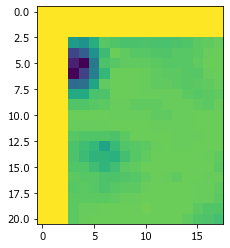

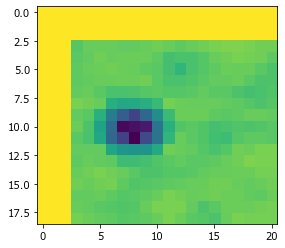

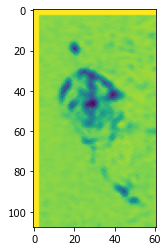

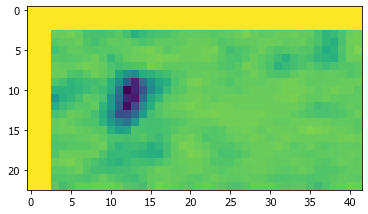

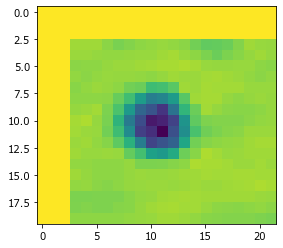

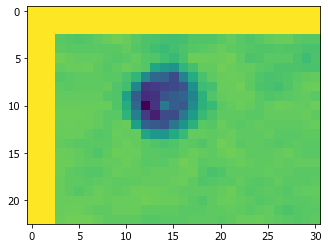

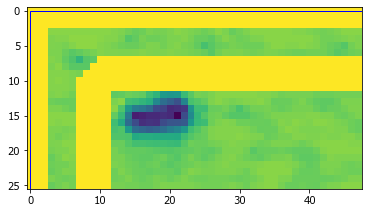

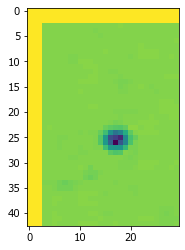

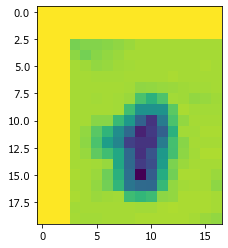

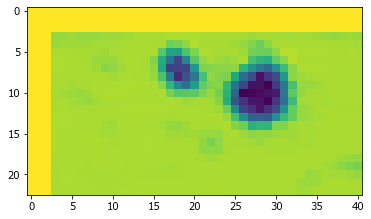

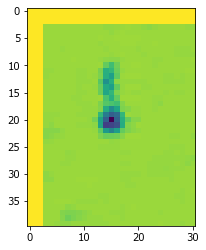

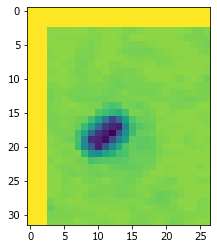

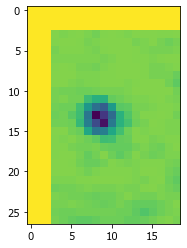

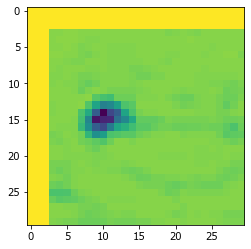

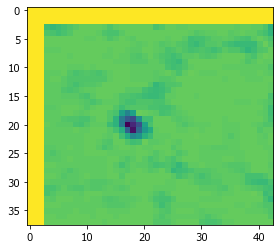

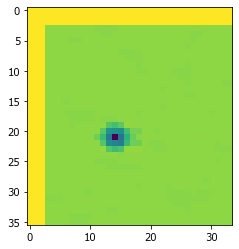

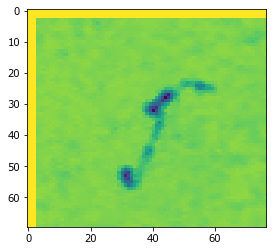

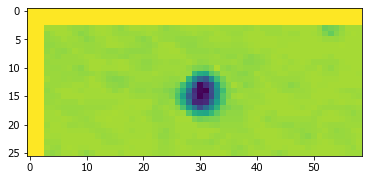

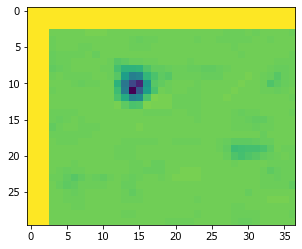

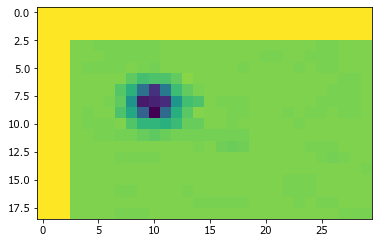

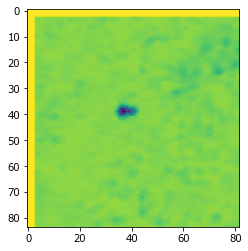

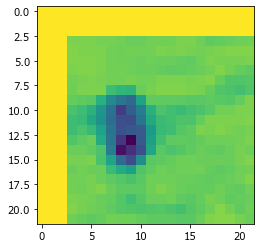

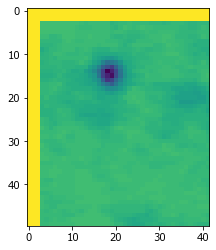

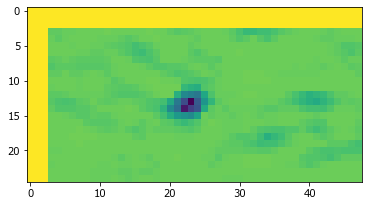

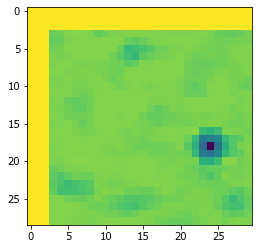

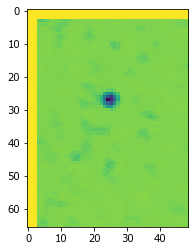

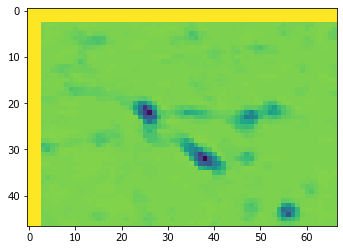

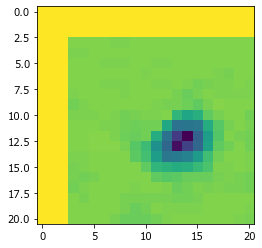

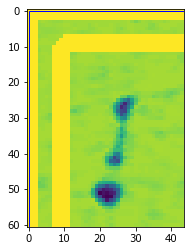

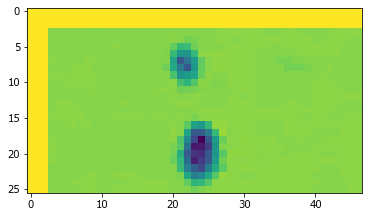

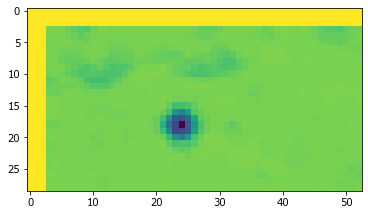

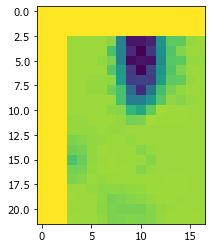

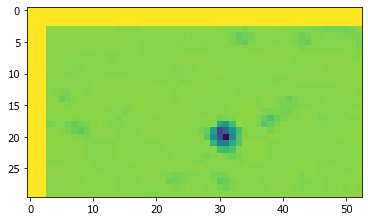

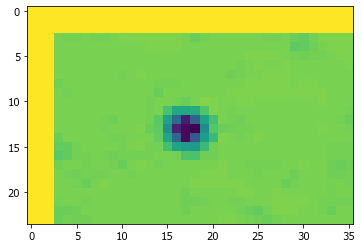

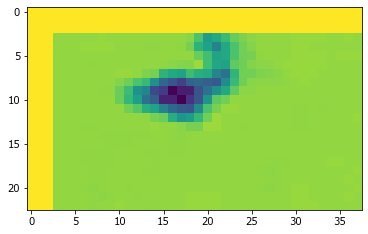

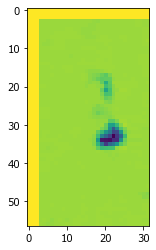

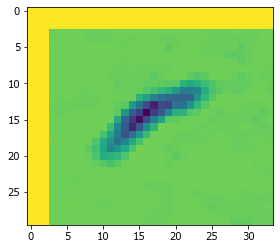

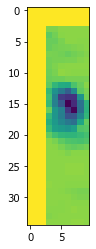

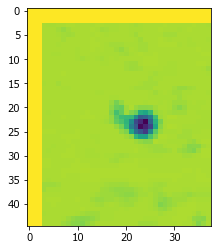

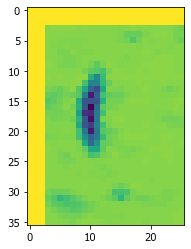

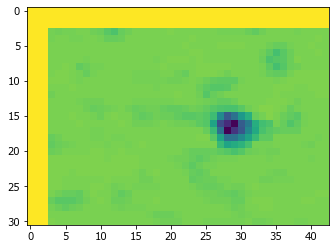

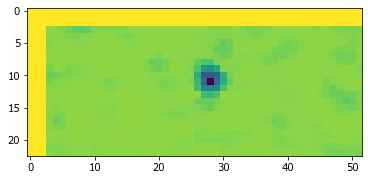

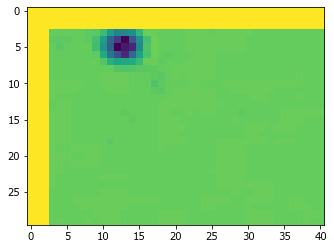

In [ ]:
IMAGES_DIR = "./Data/Trial/H6/"
ANNOTATIONS_DIR = './Data/Trial/Labeled H6/'
IMG_WIDTH = 1280
IMG_HEIGHT = 1024


for file in os.listdir(IMAGES_DIR):
    image_id = file[:-4]

    image_path = IMAGES_DIR + image_id + '.tif'
    annotation_path = ANNOTATIONS_DIR + image_id + '_20X_YZ.json'
    new_annotation_path = ANNOTATIONS_DIR + image_id + '_20X_YZ_generated_labels.json'

    whole_data, boxes = extract_boxes(annotation_path) # extract mask data from json file
    fig, ax = plt.subplots()

    img, img_border, contours = process_image(image_path)
    
    #cv2.drawContours(img, contours, -1, (215, 252,3), 3)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))


    #get a bounding box for each contour
    #arbitrary thresholds to filter out tiny dots and big defects like cracks
    all_boxes = [cv2.boundingRect(c) for c in contours if cv2.contourArea(c) > 150 and cv2.contourArea(c) < 500000 ]

    #turn coordinates into Rectangle patch
    bounding_rectangles = [Rectangle((max(0, b[0]-BORDER_WIDTH), max(0, b[1]-BORDER_WIDTH)), b[2], b[3],
    facecolor='none', edgecolor='b') for b in all_boxes]

    for r in bounding_rectangles:
        ax.add_patch(r)

    whole_data["shapes"] = []

    for box in boxes: #for each of labeled instances
        rect = None
        if box['points']:
            upper_right_corner = (min(box['points'][0][0], box['points'][1][0]), min(box['points'][0][1], box['points'][1][1]))
            lower_left_corner = (max(box['points'][0][0], box['points'][1][0]), max(box['points'][0][1], box['points'][1][1]))
            rect = Rectangle(upper_right_corner, lower_left_corner[0]-upper_right_corner[0],lower_left_corner[1]-upper_right_corner[1])
            
            small_img = img[int(upper_right_corner[1]):int(lower_left_corner[1]), int(upper_right_corner[0]):int(lower_left_corner[0])]
            
            small_img = cv2.cvtColor(small_img, cv2.COLOR_BGR2GRAY)
            contours_1, hierarchy_1 = cv2.findContours(small_img, cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
            hull_list = []
            for c in contours_1:
                hull = cv2.convexHull(c)
                hull_list.append(hull)
            cv2.drawContours(small_img, contours, -1, (255, 255,255), 3)
            plt.imshow(small_img)
        
        common = []
       
        if rect:
            #get all generated bb that overlap with manual bb
            for r in bounding_rectangles:
                overlap = overlap_area(r, rect)
                if overlap.get_height()*overlap.get_width() > 0 and r.get_width()*r.get_height() < rect.get_height()*rect.get_width()+50:
                    common.append(r)

            instance = {}
            instance["label"] = box["label"]
            instance["points"] = []
            instance["shape_type"] = "rectangle"
            instance["group_id"] = None
            instance["flags"] = {}
            color = "r"

            if len(common) == 1:
                #choose the generated bb as the new bounding box
                instance["points"].append([common[0].xy[0]+common[0].get_width(), common[0].xy[1]+common[0]
                                          .get_height()])
                instance["points"].append([common[0].xy[0], common[0].xy[1]])
                color ="g"

            elif len(common) == 0:
                instance["points"].append([rect.xy[0]+rect.get_width(), rect.xy[1]+rect
                          .get_height()])
                instance["points"].append([rect.xy[0], rect.xy[1]])
            else:
                points = []
                for rectangle in common:
                    points.append([rectangle.get_x(), rectangle.get_y()])
                    points.append([rectangle.get_x()+rectangle.get_width(), rectangle.get_y()+rectangle.get_height()])

                rect_overlap = get_max_bb(points)
                instance["points"].append([rect_overlap[1][0], rect_overlap[1][1]])
                instance["points"].append([rect_overlap[0][0],rect_overlap[0][1]])
                color ="g"

            whole_data["shapes"].append(instance)
            rect = Rectangle((instance["points"][0][0], instance["points"][0][1]),
                             instance["points"][1][0]-instance["points"][0][0],instance["points"][1][1]-instance["points"][0][1],
                         linewidth=1, edgecolor=color,
                         facecolor='none')
            ax.add_patch(rect)

    new_json = open(new_annotation_path, "w")
    new_json.write(json.dumps(whole_data))
    new_json.close()

    plt.show()

